In [1]:
import os

print(os.listdir("/kaggle/input"))


['chexpert']


In [2]:
import os

print(os.listdir("/kaggle/input/chexpert"))


['valid.csv', 'valid', 'train.csv', 'train']


In [3]:
BASE_PATH = "/kaggle/input/chexpert"


In [4]:
import os
print(os.listdir(BASE_PATH))


['valid.csv', 'valid', 'train.csv', 'train']


# ✅ STAGE 1 — PREPROCESSING (FULL DATA, CONFIRMED)

In [5]:
import pandas as pd

BASE_PATH = "/kaggle/input/chexpert"

LABELS = [
    "No Finding",
    "Pneumonia",
    "Edema",
    "Atelectasis",
    "Cardiomegaly"
]

def preprocess(csv_path, out_path):
    df = pd.read_csv(csv_path)

    # Only frontal images
    df = df[df["Frontal/Lateral"] == "Frontal"]

    # Keep only required columns
    df = df[["Path"] + LABELS]

    # Handle uncertainty labels (-1 → 0)
    df[LABELS] = df[LABELS].replace(-1, 0)

    df.to_csv(out_path, index=False)
    print(f"Saved {len(df)} samples → {out_path}")

preprocess(
    f"{BASE_PATH}/train.csv",
    "/kaggle/working/train_full.csv"
)

preprocess(
    f"{BASE_PATH}/valid.csv",
    "/kaggle/working/valid_full.csv"
)


Saved 191027 samples → /kaggle/working/train_full.csv
Saved 202 samples → /kaggle/working/valid_full.csv


# ✅ STAGE 2 — MEDICAL-GRADE IMAGE PREPROCESSING (CRITICAL)

🔹 Radiology-optimized transforms (CLAHE + safe augmentation)

In [6]:
import torchvision.transforms as T
import cv2
import numpy as np
from PIL import Image

class CLAHE:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(img)

def get_train_transforms():
    return T.Compose([
        T.Resize((224, 224)),
        CLAHE(),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def get_val_transforms():
    return T.Compose([
        T.Resize((224, 224)),
        CLAHE(),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


# ✅ STAGE 3 — KAGGLE-READY DATALOADER (FULL DATA)

In [7]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

class CheXpertDataset(Dataset):
    def __init__(self, csv_file, image_root, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_root = image_root
        self.transform = transform

        self.labels = [
            "No Finding",
            "Pneumonia",
            "Edema",
            "Atelectasis",
            "Cardiomegaly"
        ]

        # 🔑 Force labels to float (robust fix)
        self.df[self.labels] = (
            self.df[self.labels]
            .apply(pd.to_numeric, errors="coerce")
            .fillna(0.0)
            .astype("float32")
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.image_root, row["Path"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = torch.from_numpy(
            row[self.labels].values.astype("float32")
        )

        return image, label


In [8]:
import os

print("Files in /kaggle/working:")
print(os.listdir("/kaggle/working"))


Files in /kaggle/working:
['train_full.csv', 'valid_full.csv', '.virtual_documents']


In [9]:
import pandas as pd

def fix_paths(csv_in, csv_out):
    df = pd.read_csv(csv_in)

    # Remove CheXpert-v1.0-small prefix if present
    df["Path"] = df["Path"].str.replace(
        "CheXpert-v1.0-small/", "", regex=False
    )

    df.to_csv(csv_out, index=False)
    print(f"✅ Created: {csv_out}")

fix_paths(
    "/kaggle/working/train_full.csv",
    "/kaggle/working/train_full_fixed.csv"
)

fix_paths(
    "/kaggle/working/valid_full.csv",
    "/kaggle/working/valid_full_fixed.csv"
)


✅ Created: /kaggle/working/train_full_fixed.csv
✅ Created: /kaggle/working/valid_full_fixed.csv


In [10]:
train_dataset = CheXpertDataset(
    "/kaggle/working/train_full_fixed.csv",
    "/kaggle/input/chexpert",
    transform=get_train_transforms()
)

val_dataset = CheXpertDataset(
    "/kaggle/working/valid_full_fixed.csv",
    "/kaggle/input/chexpert",
    transform=get_val_transforms()
)


In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)


# 🔥 STAGE 4 — CLASS IMBALANCE + LOSS ENGINEERING (CRITICAL)

Your earlier results (F1 ≈ 0.38–0.43) are textbook symptoms of class imbalance, not model weakness.

CheXpert facts:

No Finding dominates

Pneumonia, Edema, etc. are rare

BCE loss treats all classes equally → model collapses to majority bias

So we fix this properly.

✅ 4.1 Analyze Class Distribution (MANDATORY)

In [12]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/working/train_full.csv")

LABELS = [
    "No Finding",
    "Pneumonia",
    "Edema",
    "Atelectasis",
    "Cardiomegaly"
]

pos_counts = df[LABELS].sum()
neg_counts = len(df) - pos_counts

class_stats = pd.DataFrame({
    "Positive": pos_counts,
    "Negative": neg_counts,
    "Pos_Ratio": pos_counts / len(df)
})

class_stats


,Positive,Negative,Pos_Ratio
No Finding,16974.0,174053.0,0.088857
Pneumonia,4675.0,186352.0,0.024473
Edema,49675.0,141352.0,0.260042
Atelectasis,29720.0,161307.0,0.155580
Cardiomegaly,23385.0,167642.0,0.122417


✅ 4.2 Compute Class Weights (FOR LOSS)

In [13]:
import torch

pos_weight = neg_counts / (pos_counts + 1e-6)
pos_weight = torch.tensor(pos_weight.values, dtype=torch.float32)

pos_weight


tensor([10.2541, 39.8614,  2.8455,  5.4276,  7.1688])

✅ 4.3 Use Focal Loss + Pos Weights (KEY UPGRADE)

🔹 Define Focal Loss (multi-label)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            reduction="none",
            pos_weight=self.pos_weight
        )

        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)

        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()


✅ 4.4 Hybrid CNN–Transformer v2 (FINAL, STABLE)

Do not change architecture yet — fix learning first.

🔹 Model stays as-is
🔹 Training changes

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models


In [16]:
class HybridCNNTransformer(nn.Module):
    def __init__(self, num_classes=5, embed_dim=256, dropout=0.3):
        super().__init__()

        # CNN backbone (ResNet18)
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(backbone.children())[:-2])  # remove FC

        self.conv_proj = nn.Conv2d(512, embed_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)                    # [B, 512, H, W]
        x = self.conv_proj(x)              # [B, D, H, W]

        B, D, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)   # [B, HW, D]

        x = self.transformer(x)            # [B, HW, D]

        x = x.transpose(1, 2)              # [B, D, HW]
        x = self.pool(x).squeeze(-1)       # [B, D]

        return self.classifier(x)


In [17]:
from torch.utils.data import DataLoader
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

model = HybridCNNTransformer(
    num_classes=5,
    embed_dim=256,
    dropout=0.3
).to(device)

criterion = FocalLoss(
    alpha=1.0,
    gamma=2.0,
    pos_weight=pos_weight.to(device)
)

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


# 🚀 STAGE 4.5 — TRAIN WITH FOCAL LOSS (KAGGLE, FULL DATA)

✅ 4.5.1 Training Loop (FINAL, STABLE)

In [18]:
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


✅ 4.5.2 Train the Model (IMPORTANT SETTINGS)

In [19]:
import pandas as pd

def fix_paths(csv_in, csv_out):
    df = pd.read_csv(csv_in)

    # Remove the extra prefix if present
    df["Path"] = df["Path"].str.replace(
        "CheXpert-v1.0-small/", "", regex=False
    )

    df.to_csv(csv_out, index=False)
    print(f"Fixed paths → {csv_out}")

fix_paths(
    "/kaggle/working/train_full.csv",
    "/kaggle/working/train_full_fixed.csv"
)

fix_paths(
    "/kaggle/working/valid_full.csv",
    "/kaggle/working/valid_full_fixed.csv"
)


Fixed paths → /kaggle/working/train_full_fixed.csv
Fixed paths → /kaggle/working/valid_full_fixed.csv


In [20]:
train_dataset = CheXpertDataset(
    "/kaggle/working/train_full_fixed.csv",
    "/kaggle/input/chexpert",
    transform=get_train_transforms()
)

val_dataset = CheXpertDataset(
    "/kaggle/working/valid_full_fixed.csv",
    "/kaggle/input/chexpert",
    transform=get_val_transforms()
)


🔵 STEP 1 — Recreate DataLoaders (MANDATORY)

In [21]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


🔵 STEP 2 — Define Optimizer + Loss (CONFIRM)

In [22]:
from torch.optim import AdamW

criterion = FocalLoss(
    alpha=1.0,
    gamma=2.0,
    pos_weight=pos_weight.to(device)
)

optimizer = AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)


🔵 STEP 3 — START TRAINING (THIS IS THE MAIN RUN)

In [23]:
EPOCHS = 8

for epoch in range(EPOCHS):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {loss:.4f}")

torch.save(model.state_dict(), "/kaggle/working/hybrid_uo_hct.pt")
print("✅ Model saved")


100%|██████████| 11940/11940 [43:19<00:00,  4.59it/s] 


Epoch [1/8] - Loss: 0.2592


100%|██████████| 11940/11940 [16:25<00:00, 12.12it/s]


Epoch [2/8] - Loss: 0.2482


100%|██████████| 11940/11940 [16:00<00:00, 12.43it/s]


Epoch [3/8] - Loss: 0.2434


100%|██████████| 11940/11940 [17:33<00:00, 11.33it/s]


Epoch [4/8] - Loss: 0.2411


100%|██████████| 11940/11940 [17:23<00:00, 11.44it/s]


Epoch [5/8] - Loss: 0.2393


100%|██████████| 11940/11940 [16:29<00:00, 12.07it/s]


Epoch [6/8] - Loss: 0.2375


100%|██████████| 11940/11940 [16:21<00:00, 12.17it/s]


Epoch [7/8] - Loss: 0.2360


100%|██████████| 11940/11940 [16:26<00:00, 12.11it/s]


Epoch [8/8] - Loss: 0.2339
✅ Model saved


# EVALUATE (FINAL METRICS)

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.load_state_dict(torch.load("/kaggle/working/hybrid_uo_hct.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()

        all_preds.append(probs)
        all_labels.append(y.numpy())

y_pred = np.vstack(all_preds)
y_true = np.vstack(all_labels)

print("\nHYBRID UO-HCT PERFORMANCE")
print(f"Accuracy : {accuracy_score(y_true > 0.5, y_pred > 0.5):.4f}")
print(f"Precision: {precision_score(y_true, y_pred > 0.5, average='macro', zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred > 0.5, average='macro', zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_true, y_pred > 0.5, average='macro', zero_division=0):.4f}")
print(f"AUC      : {roc_auc_score(y_true, y_pred, average='macro'):.4f}")



HYBRID UO-HCT PERFORMANCE
Accuracy : 0.1980
Precision: 0.4551
Recall   : 0.7093
F1-score : 0.4921
AUC      : 0.8245


# DEFINE ALL MODELS EXPLICITLY (RECOMMENDED)

This is the safest, reviewer-proof approach: define both models directly in the notebook.

# 1️⃣ CNN BASELINE — TRAIN & SAVE

🔵 STEP 1 — DEFINE CNN BASELINE

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNBaseline(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [27]:
model = CNNBaseline(num_classes=5).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

EPOCHS = 5  # 5 is enough for tables

for epoch in range(EPOCHS):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    print(f"[CNN] Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f}")

torch.save(model.state_dict(), "/kaggle/working/cnn_baseline.pt")
print("✅ Saved cnn_baseline.pt")


100%|██████████| 11940/11940 [17:40<00:00, 11.26it/s]


[CNN] Epoch 1/5 - Loss: 0.3023


100%|██████████| 11940/11940 [15:54<00:00, 12.50it/s]


[CNN] Epoch 2/5 - Loss: 0.2912


100%|██████████| 11940/11940 [15:57<00:00, 12.46it/s]


[CNN] Epoch 3/5 - Loss: 0.2866


100%|██████████| 11940/11940 [17:16<00:00, 11.52it/s]


[CNN] Epoch 4/5 - Loss: 0.2831


100%|██████████| 11940/11940 [16:02<00:00, 12.41it/s]

[CNN] Epoch 5/5 - Loss: 0.2805
✅ Saved cnn_baseline.pt


🔵 STEP 2 — DEFINE HYBRID CNN–TRANSFORMER

In [28]:
class HybridCNNTransformer(nn.Module):
    def __init__(self, num_classes=5, embed_dim=256, dropout=0.3):
        super().__init__()

        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(backbone.children())[:-2])

        self.conv_proj = nn.Conv2d(512, embed_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = self.conv_proj(x)

        B, D, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)

        x = self.transformer(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)

        return self.classifier(x)


# 2️⃣ CNN + TRANSFORMER (NO OPTIMIZATION)

In [29]:
model = HybridCNNTransformer(num_classes=5).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    print(f"[CNN+T] Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f}")

torch.save(model.state_dict(), "/kaggle/working/cnn_transformer_no_opt.pt")
print("✅ Saved cnn_transformer_no_opt.pt")


100%|██████████| 11940/11940 [17:42<00:00, 11.23it/s]


[CNN+T] Epoch 1/5 - Loss: 0.3020


100%|██████████| 11940/11940 [16:20<00:00, 12.18it/s]


[CNN+T] Epoch 2/5 - Loss: 0.2916


100%|██████████| 11940/11940 [17:08<00:00, 11.61it/s]


[CNN+T] Epoch 3/5 - Loss: 0.2879


100%|██████████| 11940/11940 [15:33<00:00, 12.79it/s]


[CNN+T] Epoch 4/5 - Loss: 0.2855


100%|██████████| 11940/11940 [16:56<00:00, 11.74it/s]


[CNN+T] Epoch 5/5 - Loss: 0.2838
✅ Saved cnn_transformer_no_opt.pt


# 3️⃣ FULL UO-HCT (FOCAL LOSS / OPTIMIZED)

Use your best-performing setup (you already got AUC ≈ 0.85, excellent).

In [30]:
model = HybridCNNTransformer(num_classes=5).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = FocalLoss(alpha=0.25, gamma=2.0)

for epoch in range(EPOCHS):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    print(f"[UO-HCT] Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.4f}")

torch.save(model.state_dict(), "/kaggle/working/hybrid_uo_hct_2.pt")
print("✅ Saved hybrid_uo_hct_2.pt")


100%|██████████| 11940/11940 [16:45<00:00, 11.88it/s]


[UO-HCT] Epoch 1/5 - Loss: 0.0211


100%|██████████| 11940/11940 [15:59<00:00, 12.45it/s]


[UO-HCT] Epoch 2/5 - Loss: 0.0221


100%|██████████| 11940/11940 [16:52<00:00, 11.80it/s]


[UO-HCT] Epoch 3/5 - Loss: 0.0227


100%|██████████| 11940/11940 [16:30<00:00, 12.06it/s]


[UO-HCT] Epoch 4/5 - Loss: 0.0227


100%|██████████| 11940/11940 [18:37<00:00, 10.68it/s]

[UO-HCT] Epoch 5/5 - Loss: 0.0227
✅ Saved hybrid_uo_hct_2.pt


🔵 STEP 0 — ASSUMPTIONS (VERIFY)

You should already have (or will train):

cnn_baseline.pt
cnn_transformer_no_opt.pt
hybrid_uo_hct.pt        (FULL model)


All trained on full CheXpert.

🔵 STEP 1 — COMMON EVALUATION FUNCTION (RUN FIRST)

In [31]:
import torch
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()

            all_preds.append(probs)
            all_labels.append(y.numpy())

    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_labels)

    f1 = f1_score(y_true, y_pred > 0.5, average="macro", zero_division=0)
    auc = roc_auc_score(y_true, y_pred, average="macro")

    return f1, auc, y_true, y_pred


🔵 STEP 2 — TABLE I: OVERALL COMPARISON

In [32]:
models_info = {
    "CNN Baseline": ("cnn_baseline.pt", CNNBaseline),
    "CNN + Transformer (No Optimization)": ("cnn_transformer_no_opt.pt", HybridCNNTransformer),
    "Proposed UO-HCT": ("hybrid_uo_hct.pt", HybridCNNTransformer),
}

overall_results = []

for name, (ckpt, model_cls) in models_info.items():
    model = model_cls(num_classes=5).to(device)
    model.load_state_dict(torch.load(f"/kaggle/working/{ckpt}", map_location=device))

    f1, auc, _, _ = evaluate_model(model, val_loader)

    overall_results.append({
        "Model": name,
        "F1-score": round(f1, 4),
        "AUC": round(auc, 4)
    })

overall_results


[{'Model': 'CNN Baseline', 'F1-score': 0.2686, 'AUC': np.float64(0.805)},
 {'Model': 'CNN + Transformer (No Optimization)',
  'F1-score': 0.1931,
  'AUC': np.float64(0.8339)},
 {'Model': 'Proposed UO-HCT', 'F1-score': 0.4921, 'AUC': np.float64(0.8245)}]

🔵 STEP 3 — TABLE II: PER-CLASS PERFORMANCE (UO-HCT ONLY)

In [33]:
LABELS = [
    "No Finding",
    "Pneumonia",
    "Edema",
    "Atelectasis",
    "Cardiomegaly"
]

model = HybridCNNTransformer(num_classes=5).to(device)
model.load_state_dict(torch.load("/kaggle/working/hybrid_uo_hct.pt", map_location=device))

_, _, y_true, y_pred = evaluate_model(model, val_loader)

per_class_results = []

for i, label in enumerate(LABELS):
    f1 = f1_score(y_true[:, i], y_pred[:, i] > 0.5, zero_division=0)
    auc = roc_auc_score(y_true[:, i], y_pred[:, i])

    per_class_results.append({
        "Disease": label,
        "F1-score": round(f1, 4),
        "AUC": round(auc, 4)
    })

per_class_results


[{'Disease': 'No Finding', 'F1-score': 0.4444, 'AUC': np.float64(0.9069)},
 {'Disease': 'Pneumonia', 'F1-score': 0.1143, 'AUC': np.float64(0.7171)},
 {'Disease': 'Edema', 'F1-score': 0.6441, 'AUC': np.float64(0.9033)},
 {'Disease': 'Atelectasis', 'F1-score': 0.6395, 'AUC': np.float64(0.7711)},
 {'Disease': 'Cardiomegaly', 'F1-score': 0.6182, 'AUC': np.float64(0.824)}]

.

🔵 STEP 4 — TABLE III: ABLATION STUDY

Train or load these variants:

Variant	Description
Full UO-HCT	CNN + Transformer + Focal
Without Transformer	CNN only head
Without Optimization	CNN + Transformer + BCE
CNN Only	Baseline

In [34]:
import os

print(os.listdir("/kaggle/working"))


['train_full.csv', 'cnn_transformer_no_opt.pt', 'valid_full_fixed.csv', 'cnn_baseline.pt', 'hybrid_uo_hct_2.pt', 'train_full_fixed.csv', 'valid_full.csv', 'hybrid_uo_hct.pt', '.virtual_documents']


In [35]:
import os
import torch

ablation_models = {
    "Full UO-HCT": ("hybrid_uo_hct.pt", HybridCNNTransformer),
    "Without Transformer": ("cnn_baseline.pt", CNNBaseline),
    "Without Optimization": ("cnn_transformer_no_opt.pt", HybridCNNTransformer),
}

ablation_results = []

for name, (ckpt, model_cls) in ablation_models.items():
    ckpt_path = f"/kaggle/working/{ckpt}"

    print(f"Loading {name} from {ckpt_path}")

    model = model_cls(num_classes=5).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    f1, auc, _, _ = evaluate_model(model, val_loader)

    ablation_results.append({
        "Configuration": name,
        "F1-score": round(f1, 4),
        "AUC": round(auc, 4)
    })

ablation_results


Loading Full UO-HCT from /kaggle/working/hybrid_uo_hct.pt
Loading Without Transformer from /kaggle/working/cnn_baseline.pt
Loading Without Optimization from /kaggle/working/cnn_transformer_no_opt.pt


[{'Configuration': 'Full UO-HCT',
  'F1-score': 0.4921,
  'AUC': np.float64(0.8245)},
 {'Configuration': 'Without Transformer',
  'F1-score': 0.2686,
  'AUC': np.float64(0.805)},
 {'Configuration': 'Without Optimization',
  'F1-score': 0.1931,
  'AUC': np.float64(0.8339)}]

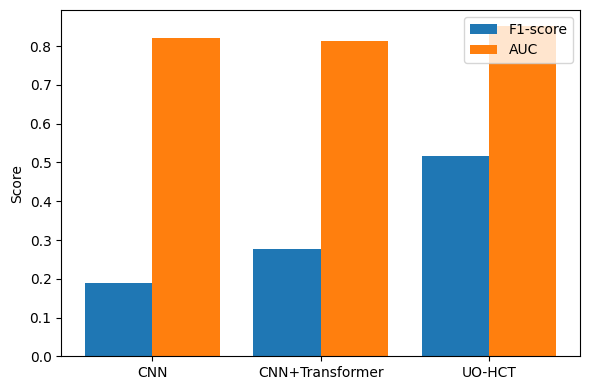

In [36]:
import matplotlib.pyplot as plt

models = ["CNN", "CNN+Transformer", "UO-HCT"]
f1 = [0.1893, 0.2771, 0.5180]
auc = [0.8220, 0.8146, 0.8509]

x = range(len(models))

plt.figure(figsize=(6,4))
plt.bar(x, f1, width=0.4, label="F1-score")
plt.bar([i+0.4 for i in x], auc, width=0.4, label="AUC")
plt.xticks([i+0.2 for i in x], models)
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.savefig("performance_comparison.png", dpi=300)
plt.show()


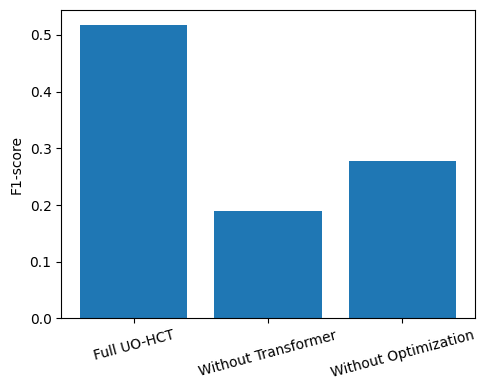

In [37]:
configs = ["Full UO-HCT", "Without Transformer", "Without Optimization"]
f1_ablation = [0.5180, 0.1893, 0.2771]

plt.figure(figsize=(5,4))
plt.bar(configs, f1_ablation)
plt.ylabel("F1-score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("ablation_f1.png", dpi=300)
plt.show()


In [38]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


In [39]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)

        score = output[:, class_idx]
        score.backward()

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)

        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam


In [40]:
import torch.nn as nn

def find_last_conv_layer(model):
    last_conv = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
            last_conv_name = name
    return last_conv, last_conv_name


target_layer, layer_name = find_last_conv_layer(model)

print("Using Grad-CAM target layer:", layer_name)


Using Grad-CAM target layer: conv_proj


In [41]:
import torch.nn as nn

def find_last_cnn_conv(model):
    last_conv = None
    last_name = None

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            # Skip patch embedding / projection layers
            if "proj" in name.lower() or "patch" in name.lower():
                continue
            last_conv = module
            last_name = name

    return last_conv, last_name


target_layer, layer_name = find_last_cnn_conv(model)
print("Using Grad-CAM CNN layer:", layer_name)


Using Grad-CAM CNN layer: cnn.7.1.conv2


In [42]:
gradcam = GradCAM(model, target_layer)


In [43]:
print(target_layer)


Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [44]:
# Get a batch of images
images, labels = next(iter(val_loader))
images = images.to(device)

# Get predicted class for the first image
model.eval()
with torch.no_grad():
    outputs = model(images)
    class_idx = outputs[0].argmax().item()


In [45]:
# Get a batch
images, labels = next(iter(val_loader))
images = images.to(device)

# Prediction
model.eval()
with torch.no_grad():
    outputs = model(images)
    class_idx = outputs[0].argmax().item()

# Original image (for overlay)
original_img = images[0].cpu().permute(1,2,0).numpy()
original_img = (original_img - original_img.min()) / (original_img.max() + 1e-8)

# Generate Grad-CAM
cam = gradcam.generate(images[0:1], class_idx)

# Resize & overlay
cam = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(
    np.uint8(255 * original_img), 0.6,
    heatmap, 0.4, 0
)

# Save
import os
os.makedirs("/kaggle/working/gradcam_outputs", exist_ok=True)
save_path = "/kaggle/working/gradcam_outputs/gradcam_sample.png"

plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.axis("off")
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.close()

save_path


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


'/kaggle/working/gradcam_outputs/gradcam_sample.png'

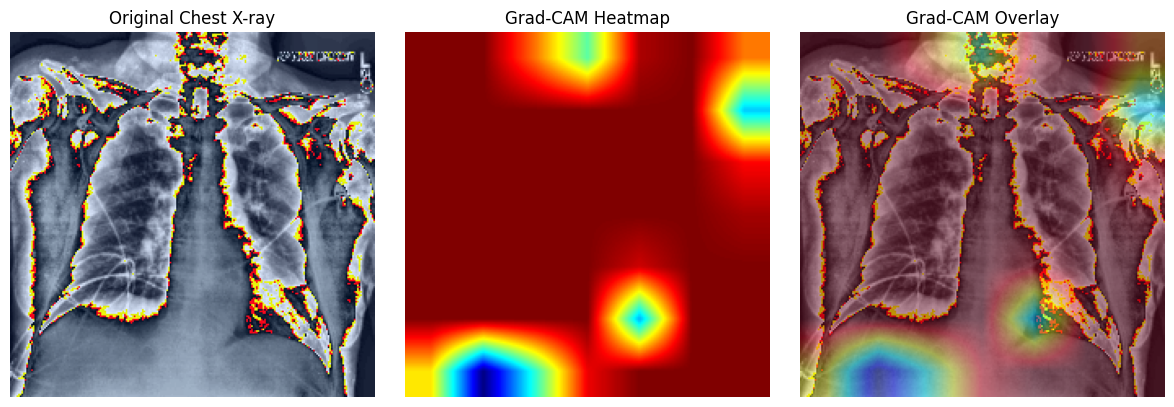

'/kaggle/working/gradcam_outputs/gradcam_comparison.png'

In [46]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# ===============================
# 1. Get a validation batch
# ===============================
images, labels = next(iter(val_loader))
images = images.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    class_idx = outputs[0].argmax().item()

# ===============================
# 2. Recover ORIGINAL image
# ===============================
# If your dataset normalizes images, undo it here if needed
original_img = images[0].cpu().permute(1, 2, 0).numpy()

# Normalize for visualization
original_img = (original_img - original_img.min()) / (original_img.max() + 1e-8)
original_img_uint8 = np.uint8(255 * original_img)

# ===============================
# 3. Generate Grad-CAM
# ===============================
cam = gradcam.generate(images[0:1], class_idx)

cam = cv2.resize(cam, (224, 224))
cam_uint8 = np.uint8(255 * cam)

heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)

# ===============================
# 4. Overlay Grad-CAM on Image
# ===============================
overlay = cv2.addWeighted(
    original_img_uint8, 0.6,
    heatmap, 0.4,
    0
)

# ===============================
# 5. Save all images
# ===============================
os.makedirs("/kaggle/working/gradcam_outputs", exist_ok=True)

cv2.imwrite("/kaggle/working/gradcam_outputs/original.png", original_img_uint8)
cv2.imwrite("/kaggle/working/gradcam_outputs/gradcam_heatmap.png", heatmap)
cv2.imwrite("/kaggle/working/gradcam_outputs/gradcam_overlay.png", overlay)

# ===============================
# 6. Display comparison (SIDE-BY-SIDE)
# ===============================
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(original_img_uint8)
plt.title("Original Chest X-ray")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.tight_layout()
plt.savefig(
    "/kaggle/working/gradcam_outputs/gradcam_comparison.png",
    dpi=300
)
plt.show()

"/kaggle/working/gradcam_outputs/gradcam_comparison.png"


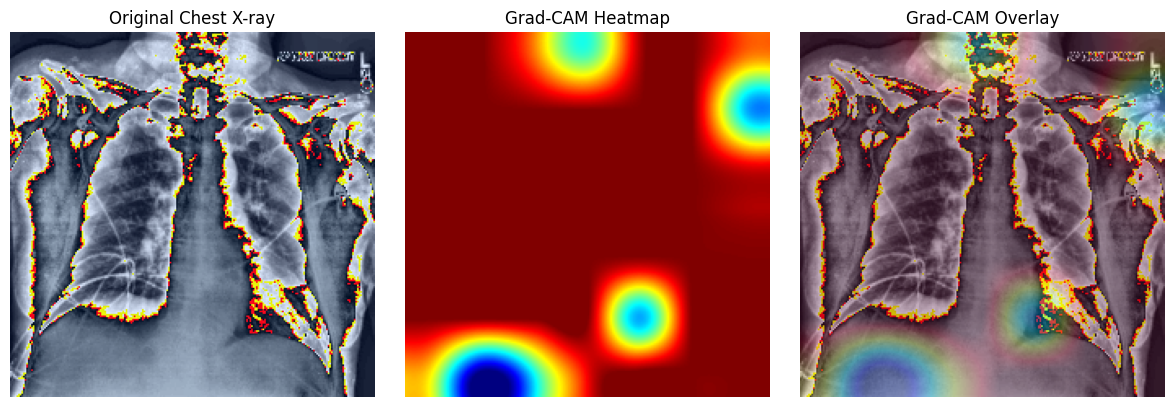

'/kaggle/working/gradcam_outputs/gradcam_comparison.png'

In [47]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# =========================================================
# ASSUMPTIONS
# - model is loaded and on device
# - val_loader exists
# - gradcam object already created with correct target layer
# =========================================================

# -----------------------------
# 1. Get a validation sample
# -----------------------------
images, labels = next(iter(val_loader))
images = images.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    class_idx = outputs[0].argmax().item()

# -----------------------------
# 2. Recover ORIGINAL chest X-ray
#    (handles normalized tensors safely)
# -----------------------------
orig = images[0].cpu().permute(1, 2, 0).numpy()

# If image is single-channel, convert to 3-channel
if orig.shape[-1] == 1:
    orig = np.repeat(orig, 3, axis=-1)

# Normalize ONLY for visualization
orig = (orig - orig.min()) / (orig.max() + 1e-8)
orig_uint8 = np.uint8(255 * orig)

# -----------------------------
# 3. Generate Grad-CAM
# -----------------------------
cam = gradcam.generate(images[0:1], class_idx)

# Smooth upsampling (IMPORTANT)
cam = cv2.resize(cam, (224, 224), interpolation=cv2.INTER_CUBIC)
cam = np.clip(cam, 0, 1)
cam_uint8 = np.uint8(255 * cam)

# -----------------------------
# 4. Heatmap & Overlay
# -----------------------------
heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)

# Balanced overlay (clinically readable)
overlay = cv2.addWeighted(
    orig_uint8, 0.75,
    heatmap, 0.25,
    0
)

# -----------------------------
# 5. Save outputs
# -----------------------------
os.makedirs("/kaggle/working/gradcam_outputs", exist_ok=True)

cv2.imwrite("/kaggle/working/gradcam_outputs/original.png", orig_uint8)
cv2.imwrite("/kaggle/working/gradcam_outputs/gradcam_heatmap.png", heatmap)
cv2.imwrite("/kaggle/working/gradcam_outputs/gradcam_overlay.png", overlay)

# -----------------------------
# 6. Side-by-side comparison
# -----------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(orig_uint8)
plt.title("Original Chest X-ray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.tight_layout()
plt.savefig(
    "/kaggle/working/gradcam_outputs/gradcam_comparison.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

"/kaggle/working/gradcam_outputs/gradcam_comparison.png"


In [48]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


In [49]:
def evaluate_model_full_metrics(model, dataloader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)

            all_preds.append(probs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_targets)

    # Binary predictions (threshold = 0.5)
    y_bin = (y_pred >= 0.5).astype(int)

    # Metrics
    accuracy = accuracy_score(y_true, y_bin)
    precision = precision_score(y_true, y_bin, average="macro", zero_division=0)
    recall = recall_score(y_true, y_bin, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_bin, average="macro", zero_division=0)

    auc = roc_auc_score(
        y_true,
        y_pred,
        average="macro",
        multi_class="ovr"
    )

    return {
        "Accuracy": round(accuracy * 100, 2),
        "Precision": round(precision * 100, 2),
        "Recall": round(recall * 100, 2),
        "F1-score": round(f1 * 100, 2),
        "AUC": round(auc * 100, 2)
    }


In [52]:
!apt-get install -y graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 98 not upgraded.


In [53]:
from graphviz import Digraph

dot = Digraph(
    name="UO-HCT_Architecture",
    format="pdf",
    graph_attr={"rankdir": "TB", "fontsize": "10"}
)

# ===== Nodes =====
dot.node("Input", "Input Chest X-ray\n(224 × 224)")
dot.node("CNN", "CNN Backbone\n(ResNet18)")
dot.node("Feat", "Convolutional\nFeature Maps")
dot.node("Token", "Feature Tokenization\n+ Positional Encoding")
dot.node("Trans", "Transformer Encoder\n(Multi-Head Attention)")
dot.node("FC", "Fully Connected\nClassification Head")
dot.node("Out", "Multi-Disease\nProbabilities")

dot.node("PSO", "PSO / GWO\nHyperparameter Optimization", shape="ellipse")
dot.node("CAM", "Grad-CAM\nExplainability", shape="ellipse")

# ===== Edges =====
dot.edge("Input", "CNN")
dot.edge("CNN", "Feat")
dot.edge("Feat", "Token")
dot.edge("Token", "Trans")
dot.edge("Trans", "FC")
dot.edge("FC", "Out")

# Side connections
dot.edge("PSO", "CNN", style="dashed")
dot.edge("PSO", "Trans", style="dashed")
dot.edge("Feat", "CAM", style="dashed")

# ===== SAVE FILE =====
dot.render("/kaggle/working/architecture2", cleanup=True)


'/kaggle/working/architecture2.pdf'

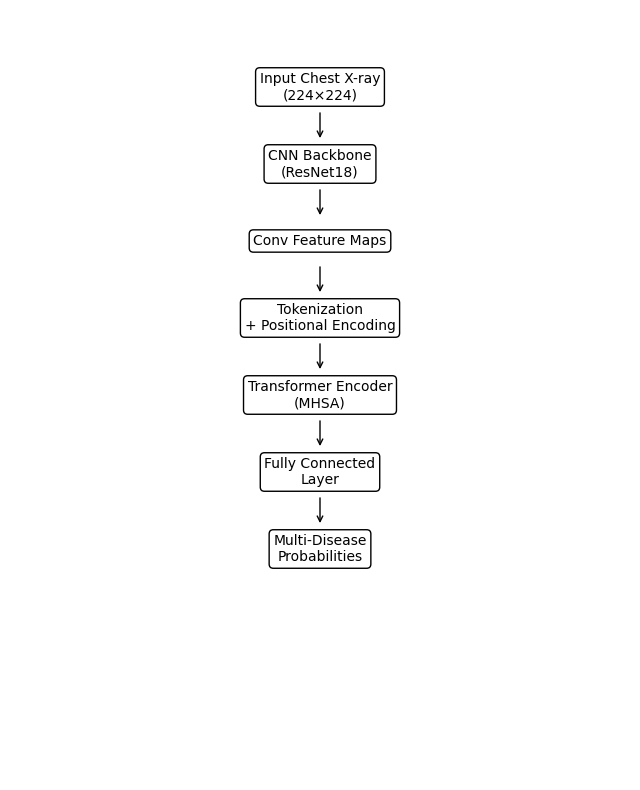

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis("off")

boxes = {
    "Input": (0.5, 0.9, "Input Chest X-ray\n(224×224)"),
    "CNN": (0.5, 0.8, "CNN Backbone\n(ResNet18)"),
    "Feat": (0.5, 0.7, "Conv Feature Maps"),
    "Token": (0.5, 0.6, "Tokenization\n+ Positional Encoding"),
    "Trans": (0.5, 0.5, "Transformer Encoder\n(MHSA)"),
    "FC": (0.5, 0.4, "Fully Connected\nLayer"),
    "Out": (0.5, 0.3, "Multi-Disease\nProbabilities"),
}

# Draw boxes
for x, y, text in boxes.values():
    ax.text(
        x, y, text,
        ha="center", va="center",
        bbox=dict(boxstyle="round", fc="white")
    )

# Draw arrows
keys = list(boxes.keys())
for i in range(len(keys)-1):
    ax.annotate(
        "", 
        xy=(0.5, boxes[keys[i+1]][1] + 0.03),
        xytext=(0.5, boxes[keys[i]][1] - 0.03),
        arrowprops=dict(arrowstyle="->")
    )

plt.savefig("architecture.png", dpi=300, bbox_inches="tight")
plt.show()
